# CS217 : Assignment 2  :  Structure From Motion

---
Please edit the cell below to include your name and student ID #

**name: Shi Zeng

**SID: 45167563

# 1. Feature Matching

## 1.1  SIFT matching library

Install an implementation of SIFT-based feature matching; I recommend using the one integrated into opencv-python. However, getting it installed is a little bit tricky because the algorithm is patented so it isn't included with some distributions. I used the recipe below to install on my system.

**conda install opencv**

**pip install opencv-contrib-python==3.4.2.16**


I have provided some example code below exercising the OpenCV SIFT matching functions. Once you are comfortable with this, please implement a function which takes as input the two images and returns the coordinates for the candidate matching points for use in the remainder of the assignment. If you decide not to use OpenCV then you should implement this function to wrap whatever version of SIFT you use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import cv2
import random

# you can use matplotlib notebook during development but
# when you print out your notebook as pdf there may be 
# problems with figures displaying so you may want to switch
# to inline
%matplotlib inline

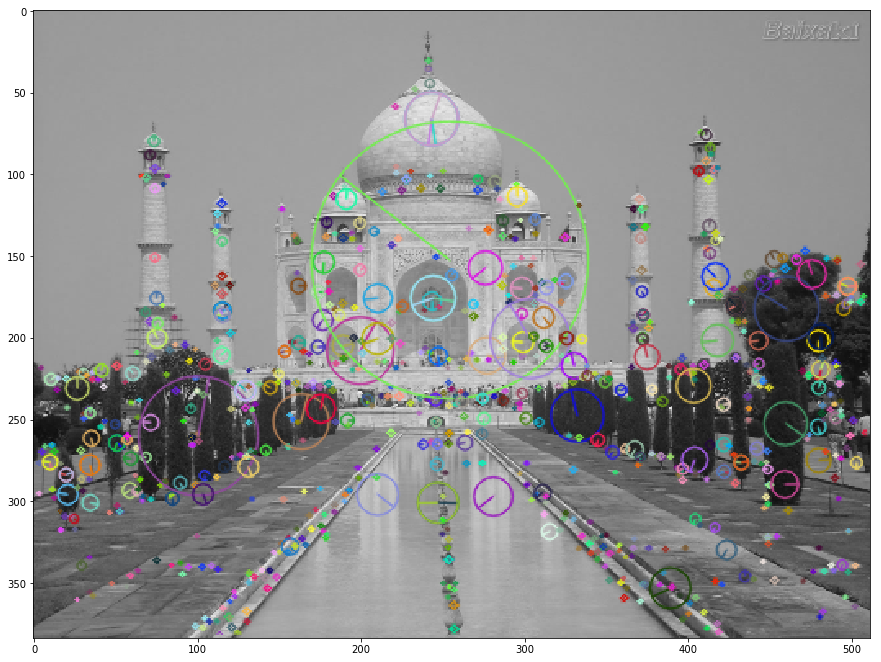

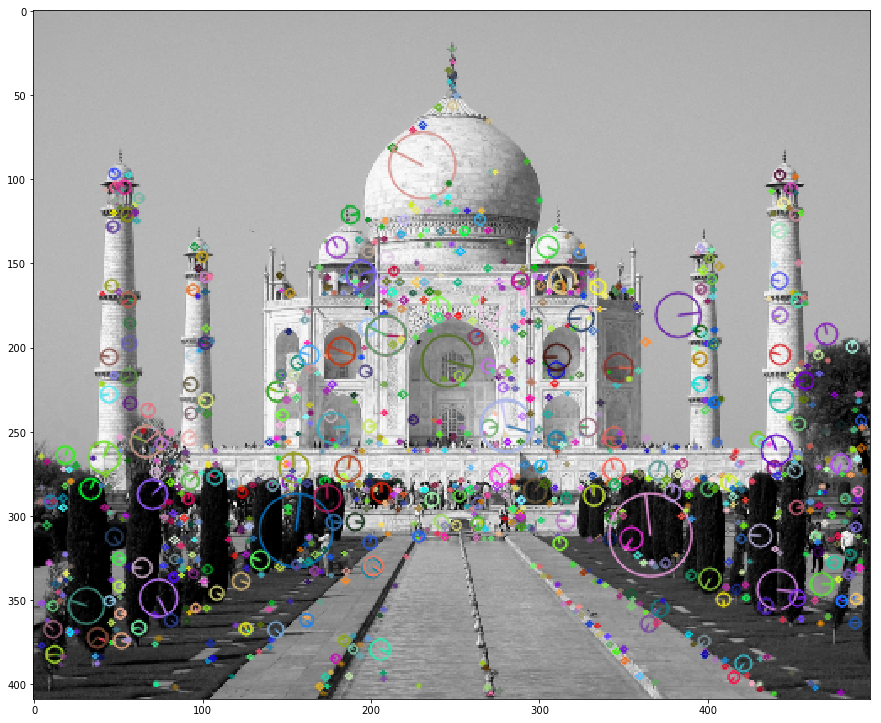

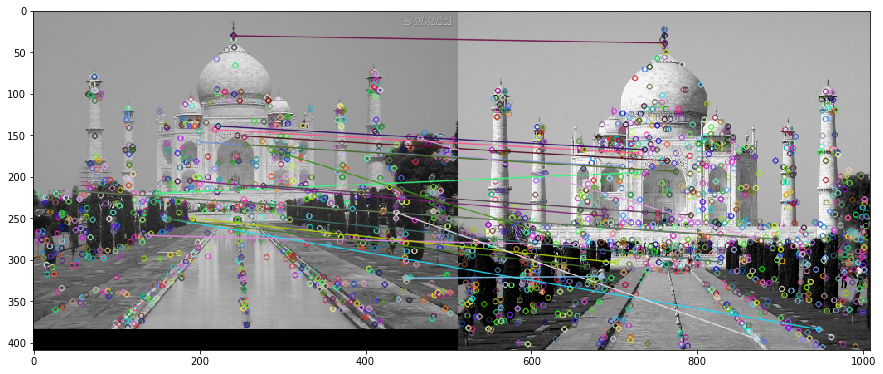

In [2]:
#
# Example code exercising the OpenCV library matching functions
#

# load in images, convert to grayscale, resize
img1 = cv2.imread('data/G.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2BGR)
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
dim = (0.4*np.asarray(gray1.shape)).astype(int)
gray1 = cv2.resize(gray1,(dim[1],dim[0]))

img2 = cv2.imread('data/H.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
dim = (0.4*np.asarray(gray2.shape)).astype(int)
gray2 = cv2.resize(gray2,(dim[1],dim[0]))


# extract SIFT feature descriptors and keypoints from each image
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

# visualize SIFT features
vis1=cv2.drawKeypoints(gray1,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis2=cv2.drawKeypoints(gray2,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(vis1)
plt.show()
plt.imshow(vis2)
plt.show()

# perform matching to find the 2 nearest neighbors for each descriptor
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# only keep a match if the distance to the 1st match is significantly
# less than the distance to the second match
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        

        
# Visualize the resulting matches. You may wish to write out the image to
# a file or open in a separate window to view at higher resolution.
img3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,good[:300],None)
plt.imshow(img3)
plt.show()


In [3]:
def loadGray(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dim = (0.4*np.asarray(gray.shape)).astype(int)
    gray = cv2.resize(gray,(dim[1],dim[0]))
    return gray

def getMatches(img1, img2):
    """
    Given two grayscale images, return a set of candidate matches using SIFT keypoint matching 
    
    Parameters
    ----------
    img1 : 2D numpy.array 
    img2 : 2D numpy.array 
            Grayscale images to match

    Returns
    -------
    pts1 : 2D numpy.array (dtype=float)
    pts2 : 2D numpy.array (dtype=float)
        Candidate pairs of matching points from img1 and img2 stored in arrays of shape (2,N)
        
    
    """   
    # extract SIFT feature descriptors and keypoints from each image
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    pts1 = []
    pts2 = []
    pairs = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            pairs.append([m])
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1).T
    pts2 = np.int32(pts2).T
    return pts1, pts2, pairs, kp1, kp2

## 1.2 Visualize SIFT candidate matches

Write code below to exercise your **getMatches** function.  Choose a pair of images you want to work with.  I've provided a few examples but you are encouraged to take your own photos or use some images off the web. Visualize the resulting set of candidate matches.  You can either modify your **getMatches** function to also return the **cv2** keypoint data structures and use **cv2.drawMatchesKnn**, or alternately come up with your own visualization technique to show correpsondences.

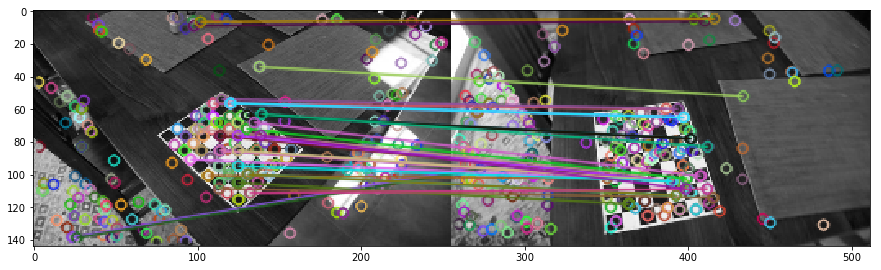

In [4]:
img1 = loadGray('data/A.jpg')
img2 = loadGray('data/B.jpg')
pts1, pts2, pairs, kp1, kp2 = getMatches(img1, img2)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, pairs[:30], None)
plt.imshow(img3)
plt.show()

# 2. Estimation of the Fundamental Matrix

As you can see from the matching results, SIFT finds matches which are not consistent with a single overall camera
motion. In order to find a consistent set of matches, implement RANSAC to estimate the fundamental matrix F. For
each random sample you should estimate F using the normalized 8 point algorithm (as described in Hartley’s paper
“In defense of ...” linked from the class website and discussed in section 4.4 of Hartley and Zisserman). You will need to experiment with the appropriate error threshold for determining inliers and outliers

In [5]:
def normalize(x):
    meanX = np.mean(x[:2], axis=1)
    S = np.sqrt(2) / np.std(x[:2])
    T = np.array([[S, 0, -S * meanX[0]], [0, S, -S * meanX[1]], [0, 0, 1]])
    x = np.dot(T, x)
    return x, T

def fitFundamental(pts2L, pts2R):
    """
    Estimate fundamental matrix from point correspondences in two views 
    
    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
    pts2R : 2D numpy.array (dtype=float)
        Coordinates of N points in the left and right view stored in arrays of shape (2,N)


    Returns
    -------
    F : 2D numpy.array (dtype=float)
        Fundamental matrix of shape (3,3)
        
    fiterror : float
        The quality of the fit measured as the average of (x^T*F*x')^2 over all corresponding points x,x'
    
    """    
    N = pts2L.shape[1]
    pL = np.concatenate((pts2L, np.ones((1, N))), axis=0)
    pR = np.concatenate((pts2R, np.ones((1, N))), axis=0)
    xL, TL = normalize(pL)
    xR, TR = normalize(pR)

    A = np.ones((9, N))
    A[0, :] = xL[0, :] * xR[0, :]
    A[1, :] = xL[0, :] * xR[1, :]
    A[2, :] = xL[0, :] * xR[2, :]
    A[3, :] = xL[1, :] * xR[0, :]
    A[4, :] = xL[1, :] * xR[1, :]
    A[5, :] = xL[1, :] * xR[2, :]
    A[6, :] = xL[2, :] * xR[0, :]
    A[7, :] = xL[2, :] * xR[1, :]
    A = A.T
    
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    F = F / F[2, 2]
    F = np.dot(TL.T, np.dot(F, TR))
    F = F / F[2, 2]
    fiterror = np.mean(np.einsum('ij, ji->i', np.dot(pL.T, F), pR)**2)
    return (F, fiterror)

In [6]:
class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 

    
    """    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

        
    def project(self,pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        ipts : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in a array of shape (N,2)

        """

        assert(pts3.shape[0]==3)

        # get point location relative to camera
        pcam = self.R.transpose() @ (pts3 - self.t)
         
        # project
        p = self.f * (pcam / pcam[2,:])
        
        # offset principal point
        pts2 = p[0:2,:] + self.c
        
        assert(pts2.shape[1]==pts3.shape[1])
        assert(pts2.shape[0]==2)
    
        return pts2

def generate_hemisphere(radius,center,npts):
    """
    Generate a set of 3D points which are randomly distributed on the
    surface of a hemisphere
    
    
    Parameters
    ----------
    radius : float
        Hemisphere radius

    center : numpy.array (dtype=float)
        3x1 vector specifying the center of the hemisphere
        
    npts : int
        number of points to generate

    Returns
    -------
    x : 2D numpy.array (dtype=float)
        3xnpts array containing coordinates of the points
        
    """
    
    assert(center.shape==(3,1))
    
    
    #generate randomly distributed points
    x = np.random.standard_normal((3,npts))
    
    #scale points to the surface of a sphere with given radius
    nx = np.sqrt(np.sum(x*x,axis=0))
    x = radius * x / nx
    
    # make points with positive z-coordinates negative
    # so that points are all on a half-sphere 
    x[2,:] = -np.abs(x[2,:])
    
    # translate to desired position
    x = x + center
    
    return x

# create a rotation matrix representing rotation around y-axis by amount theta
def roty(theta):
    st = np.sin(theta)
    ct = np.cos(theta)
    R = np.array([[ct,0,st],[0,1,0],[-st,0,ct]])
    return R


#compute rotation angle so that the camera is looking directly at the sphere

b = 5  #baseline between cameras
d = 10   #distance to object
theta = np.arctan(b/d)  
tL = np.array([[-b,0,0]]).T
tR = np.array([[b,0,0]]).T
camL = Camera(f=100,c=np.array([[50,50]]).T,t=tL,R=roty(theta))
camR = Camera(f=100,c=np.array([[50,50]]).T,t=tR,R=roty(-theta))

#generate 3D points
pts3 = generate_hemisphere(2, np.array([[0,0,d]]).T,500)

#project into each camera
pts2L = camL.project(pts3)
pts2R = camR.project(pts3)

In [7]:
#
#  I recommend debugging / testing your fitting function with some synthetic example
#  where you know what the "true" F matrix is. You can do this by generating points 
#  from two views using the project function from Assignment #1.
#
F, err = fitFundamental(pts2L, pts2R)
# F, err = fitFundamental(pts1, pts2)
print(F.T)
print(err)
Fc, mask = cv2.findFundamentalMat(pts2L.T, pts2R.T, cv2.FM_RANSAC)
# Fc, mask = cv2.findFundamentalMat(pts1.T, pts2.T, cv2.FM_RANSAC)
print(Fc)

(2,)
(2,)
[[ 1.53924046e-20  2.00000000e-04 -1.00000000e-02]
 [ 2.00000000e-04 -8.40253017e-19 -5.00000000e-02]
 [-1.00000000e-02  3.00000000e-02  1.00000000e+00]]
2.454343491368873e-31
[[ 5.24287033e-11  1.99998322e-04 -9.99992322e-03]
 [ 2.00002327e-04 -1.23204152e-09 -5.00001462e-02]
 [-1.00001129e-02  3.00002085e-02  1.00000000e+00]]


In [8]:
def random_partition(n, N):
    idxs = np.arange(N)
    np.random.shuffle(idxs)
    return idxs[:n], idxs[n:]

def get_error(F, pts2L, pts2R):
    N = pts2L.shape[1]
    pL = np.concatenate((pts2L, np.ones((1, N))), axis=0)
    pR = np.concatenate((pts2R, np.ones((1, N))), axis=0)
    FL = np.dot(F, pL)
    FR = np.dot(F, pR)
    denom = FL[0]**2 + FL[1]**2 + FR[0]**2 + FR[0]**2
    err = np.diag(np.dot(pL.T, FR))**2 / denom
    return err

def fitFundamentalRANSAC(pts2L, pts2R, thresh, niter):
    """
    Robust estimation of fundamental matrix from point correspondences in two views 
    
    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
    pts2R : 2D numpy.array (dtype=float)
            Coordinates of N points in the left and right view stored in arrays of shape (2,N)

    thresh : float
        Error threshold to decide whether a point is an inlier or outlier

    niter : int
        Number of RANSAC iterations to run
        
    Returns
    -------
    F : 2D numpy.array (dtype=float)
        Fundamental matrix of shape (3,3)
    
    inliers : numpy.array (dtype=int)
        Indices of the points which were determined to be inliers
        
    fiterror : float
        The quality of the fit measured as the average of (x^T*F*x')^2 over all corresponding points x,x'
    
    """
    N = pts2L.shape[1]
    n = 10
    inliers = None
    bestin = -1
    fiterror = np.inf
    for i in range(niter):
        fitIdx, testIdx = random_partition(n, N)
        pt2L = pts2L[:, fitIdx]
        pt2R = pts2R[:, fitIdx]
        F, error = fitFundamental(pt2L, pt2R)
        error = get_error(F, pts2L[:, testIdx], pts2R[:, testIdx])
        resIdx = testIdx[error < thresh]
        if resIdx.shape[0] > bestin:
            betIdx = np.concatenate((fitIdx, resIdx))
            F, error = fitFundamental(pts2L[:, betIdx], pts2R[:, betIdx])
            error = np.sum(error)
            bestfit = inliers
            fiterror = error
            inliers = np.concatenate((fitIdx, resIdx))
        break
    return (F,inliers,fiterror)

In [9]:
#
#  Again, it is probably good to test your RANSAC function using some toy data.
#  You can add in some random point matches as outliers and see that RANSAC 
#  correctly eliminates them.
#
F, inliers, fiterror = fitFundamentalRANSAC(pts2L, pts2R, 1e-3, 5000)
print(F.T)
print(inliers.shape)
print(fiterror)

(2,)
(2,)
(2,)
(2,)
[[-2.82329763e-20  2.00000000e-04 -1.00000000e-02]
 [ 2.00000000e-04 -5.67387501e-19 -5.00000000e-02]
 [-1.00000000e-02  3.00000000e-02  1.00000000e+00]]
(500,)
9.79757528439495e-31


***
### 2.1 Visualize Correspondences

Using the same image pairs as in Problem 1, show the best set of correspondences chosen by RANSAC as
inliers. If things are working correctly, the correspondences should be more consistent than in Problem 1 since
they all now satisfy the same epipolar constraint. Experiment with the inlier threshold and number of iterations in order to get the best result

(2,)
(2,)
(2,)
(2,)
[[-4.37543614e-07 -8.90270845e-05  2.97816291e-02]
 [ 9.67475307e-05  2.04066222e-06  5.36605402e-03]
 [-3.21096625e-02 -8.98281226e-03  1.00000000e+00]]
0.00021546694930625902
(11,)


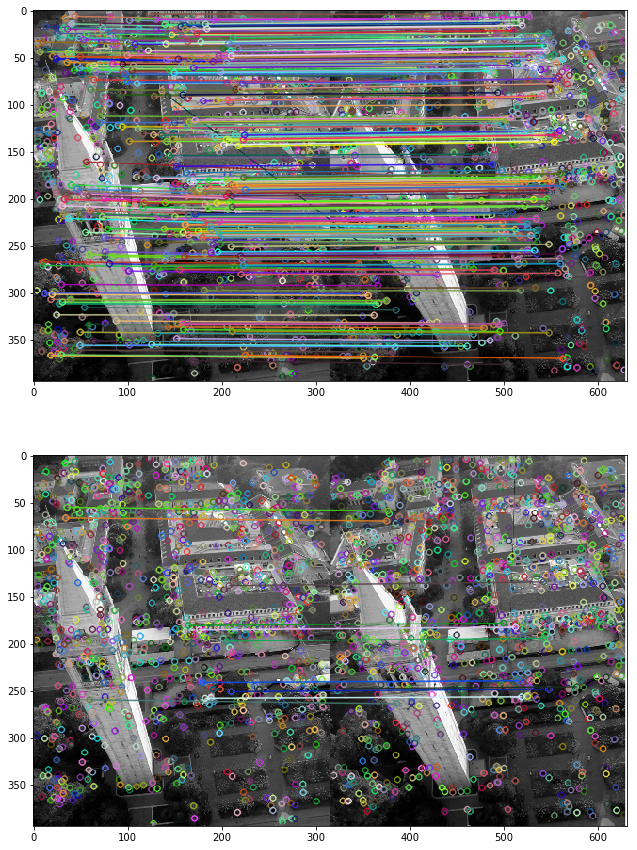

In [10]:
img1 = loadGray('data/E.jpg')
img2 = loadGray('data/F.jpg')
pts1, pts2, pairs, kp1, kp2 = getMatches(img1, img2)
pairs = np.array(pairs)
F, inliers, fiterror = fitFundamentalRANSAC(pts1, pts2, 1e-6, 5000)
print(F)
print(fiterror)
print(inliers.shape)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, pairs[:300], None)
plt.subplot(2, 1, 1)
plt.imshow(img3)
img4 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, pairs[inliers], None)
plt.subplot(2, 1, 2)
plt.imshow(img4)

***
### 2.2  Epipolar Lines

Visualize the epipolar geometry for a subset of 20 feature points in one of your image pairs. For both image
you should plot ~10 feature points along with the epipolar lines on which they should lie given your estimate of $F$ and their corresponding point in the other image. What can you say about the relative pose of the two camera views based on the arrangement of epipolar lines? Can you tell which is the "left" and "right" camera from the lines alone.

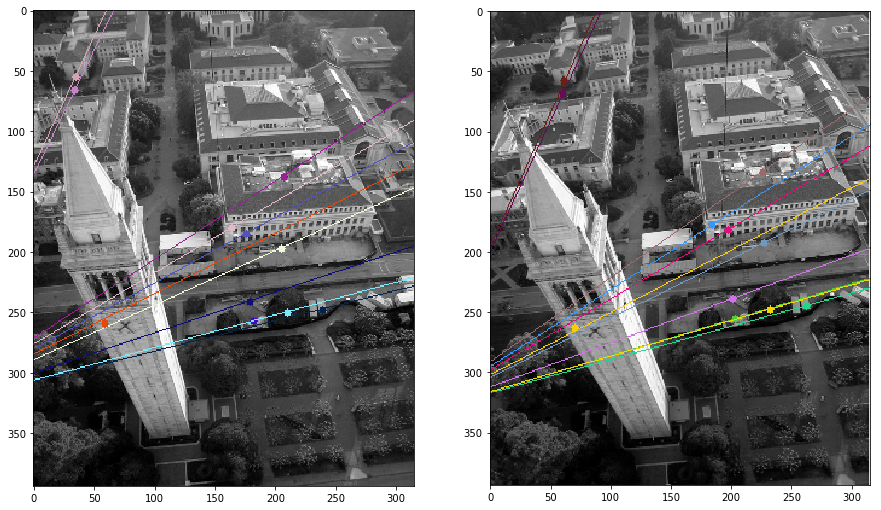

In [11]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),3,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),3,color,-1)
    return img1,img2
cpts1 = pts1[:, inliers].T
cpts2 = pts2[:, inliers].T

lines1 = cv2.computeCorrespondEpilines(cpts2.reshape(-1,1,2), 2, F.T)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1, img2, lines1, cpts1, cpts2)


lines2 = cv2.computeCorrespondEpilines(cpts1.reshape(-1,1,2), 1, F.T)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2, img1, lines2, cpts2, cpts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

### 2.3 Stability 

How stable is your estimate of F? If you rerun RANSAC multiple times with random samplings, does it always
return the same F matrix? Please write a bit of code below to carry out this experiment and compute some quantitative measure of the variability in estimated F. How could you get a more robust estimate?

In [12]:
img1 = loadGray('data/E.jpg')
img2 = loadGray('data/F.jpg')
pts1, pts2, pairs, kp1, kp2 = getMatches(img1, img2)
pairs = np.array(pairs)
N = pts1.shape[1]
for i in range(4):
    spIdx, testIdx = random_partition(N // 2, N)
    sF, sinliers, sfiterror = fitFundamentalRANSAC(pts1[:, spIdx], pts2[:, spIdx], 1e-3, 5000)
    print(np.sum(F - sF))

(2,)
(2,)
(2,)
(2,)
0.00024131465271562142
(2,)
(2,)
(2,)
(2,)
-0.003673114651180899
(2,)
(2,)
(2,)
(2,)
-0.00245334721267192
(2,)
(2,)
(2,)
(2,)
-0.010396878214882527


The algorithm does have tiny numerical change when the feature points is randomly sampled into half of its original size. To get a more robust estimate, apply an optimization on fiterror value instead of just randomly selecting points with trial and error.

# 3. Calibrated Structure From Motion



Download the calibration images provided (sfm.zip). Modify the provided camera calibration script **calibrate.py** as needed and use it to estimate the intrinsic parameter matrix K and enter the results below.

In [13]:
%matplotlib inline
import pickle
import glob
calibimgfiles = 'sfm/*.JPG'
resultfile = 'calibration.pickle'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(calibimgfiles)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Display image with the corners overlayed
        cv2.drawChessboardCorners(img, (8, 6), corners, ret)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# now perform the calibration
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

print("Estimated camera intrinsic parameter matrix K")
print(K)
print("Estimated radial distortion coefficients")
print(dist)

print("Individual intrinsic parameters")
print("fx = ", K[0][0])
print("fy = ", K[1][1])
print("cx = ", K[0][2])
print("cy = ", K[1][2])

# save the results out to a file for later use
calib = {}
calib["fx"] = K[0][0]
calib["fy"] = K[1][1]
calib["cx"] = K[0][2]
calib["cy"] = K[1][2]
calib["dist"] = dist
fid = open(resultfile, "wb")
pickle.dump(calib, fid)
fid.close()

Estimated camera intrinsic parameter matrix K
[[1.66278015e+03 0.00000000e+00 8.38090647e+02]
 [0.00000000e+00 1.66268918e+03 6.06618304e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Estimated radial distortion coefficients
[[-1.65472079e-01  3.10611096e-01 -1.57761872e-03  7.00806759e-04
  -1.55563543e+00]]
Individual intrinsic parameters
fx =  1662.7801532933238
fy =  1662.6891755715321
cx =  838.0906465722516
cy =  606.6183044039285


### 3.1 Estimate the Essential Matrix

Write code which loads in the pair of test images, use your SIFT matching routine to return a set of matching points.  Normalize these point coordinates using $K^{-1}$ and then modify your code from Problem 2 to recover the essential matrix E. Remember that you can still use the 8 point algorithm but now you will need to set the two singular values to be equal instead of just zeroing out the smallest singular value. 

In [14]:
def fitEssential(pts2L, pts2R, KL, KR):
    """
    Estimate fundamental matrix from point correspondences in two views 
    
    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
    pts2R : 2D numpy.array (dtype=float)
        Coordinates of N points in the left and right view stored in arrays of shape (2,N)


    Returns
    -------
    F : 2D numpy.array (dtype=float)
        Fundamental matrix of shape (3,3)
        
    fiterror : float
        The quality of the fit measured as the average of (x^T*F*x')^2 over all corresponding points x,x'
    
    """    
    N = pts2L.shape[1]
    pL = np.concatenate((pts2L, np.ones((1, N))), axis=0)
    pR = np.concatenate((pts2R, np.ones((1, N))), axis=0)
    xL = np.dot(np.linalg.inv(KL), pL)
    xR = np.dot(np.linalg.inv(KR), pR)

    A = np.ones((9, N))
    A[0, :] = xL[0, :] * xR[0, :]
    A[1, :] = xL[0, :] * xR[1, :]
    A[2, :] = xL[0, :] * xR[2, :]
    A[3, :] = xL[1, :] * xR[0, :]
    A[4, :] = xL[1, :] * xR[1, :]
    A[5, :] = xL[1, :] * xR[2, :]
    A[6, :] = xL[2, :] * xR[0, :]
    A[7, :] = xL[2, :] * xR[1, :]
    A = A.T
    
    U, S, Vh = np.linalg.svd(A, full_matrices=True)
    F = Vh[-1].reshape(3, 3)
    U, S, Vh = np.linalg.svd(F, full_matrices=True)
    S[-1] = 0
    t = (S[0] + S[1]) / 2.
    S[0] = t
    S[1] = t
    E = np.dot(U, np.dot(np.diag(S), Vh))
#     E = np.dot(np.dot(U, np.diag(S)), Vh)
    E = E / E[2, 2]
    return E

(2,)
(2,)
(2,)
(2,)
[[ 3.21553674e-06 -3.53028483e-06  1.30783315e-02]
 [ 1.42718840e-05 -4.17410596e-06 -9.56571650e-03]
 [-1.71476930e-02  6.79913513e-03  1.00000000e+00]]
(10,)
0.0003321511899234469
[[  4.2057004   77.44482203  22.02972326]
 [-78.36387833   4.73174576 -23.31347146]
 [-18.34579747  25.25639006   1.        ]]


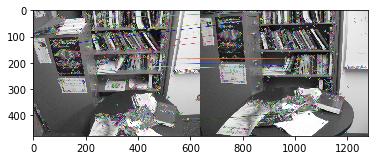

In [15]:
img1 = loadGray('sfm/IMG_1434.jpg')
img2 = loadGray('sfm/IMG_1435.jpg')
pts1, pts2, pairs, kp1, kp2 = getMatches(img1, img2)
F, inliers, fiterror = fitFundamentalRANSAC(pts1, pts2, 1e-6, 1000)
E = fitEssential(pts1[:, inliers], pts2[:, inliers], K, K)
pairs = np.array(pairs)
imgn = cv2.drawMatchesKnn(img1, kp1, img2, kp2, pairs[inliers], None)
plt.imshow(imgn)
print(F)
print(inliers.shape)
print(fiterror)
print(E)

### 3.2 Camera Pose from the Esential Matrix

Using the SVD technique we described in class, recover the two possible rotation matrices R and translation vectors t associated with E. Discuss your results. Is the recovered translation reasonable based on what you see in the images?


In [16]:
def null(A, eps = 1e-8):
    U, S, V = np.linalg.svd(A)
    null_mask = (S <= eps)
    null_space = np.compress(null_mask, V, axis=0)
    return null_space.T

def get_R(E):
    U, S, Vh = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R1 = np.dot(np.dot(U, W), Vh)
    R2 = np.dot(np.dot(U, W.T), Vh)
    if int(np.linalg.det(R1)) == -1:
        R1 = -R1
    if int(np.linalg.det(R2)) == -1:
        R2 = -R2
    return R1, R2

t = null(E)
R1, R2 = get_R(E)
print(t)
print(R1)
print(R2)

[[-0.28998317]
 [-0.24724498]
 [ 0.92454296]]
[[-0.83124     0.19339692 -0.52118874]
 [ 0.0840378  -0.88304531 -0.46170188]
 [-0.54952499 -0.42758463  0.71776993]]
[[ 0.99863695 -0.05067121 -0.01251696]
 [ 0.05103883  0.99821412  0.0310419 ]
 [ 0.01092168 -0.03163844  0.99943971]]


The right camera is translated up in the coordinate and closer to the objects. Therefore, the translate vector seems reasonable in its direction. However, the depth information is lost due to ambiguity, so the exact value of the translate vector cannot be recovered.